In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import mlxtend as ml

import mlxtend.frequent_patterns 
import mlxtend.preprocessing

In [93]:
df = pd.read_excel(r'up.xlsx',usecols=['Time Inv Date ID','SKU SKU','SKU - Formulation Desc DESC','Matl Desc ID2','QTY UOM','CUST BillTo # ID','Unit Price'])

len(df)

48250

In [94]:
## df = df.astype({"Matl # ID": str})

#Removing all rows containing service as this is redundant
df = df.astype({'CUST BillTo # ID': str})
df = df.astype({"SKU SKU": str})
df = df[~df['SKU SKU'].str.contains("SERVICE")]

#Filtering out all negatives
df = df[df['QTY UOM'] > 0]
df = df[df['Unit Price'] > 0]

#Concatenating materials
df['Matl'] = (df['SKU - Formulation Desc DESC'].fillna('') + '_' + df['Matl Desc ID2'].fillna('')).str.strip('_')

In [95]:
len(df)

41265

In [96]:
# Creating a unique index based on customer and timestamp - can eliminate this step if invoice number is given

df.insert(loc=0, column='unique_id', value=df.set_index(['CUST BillTo # ID','Time Inv Date ID']).index.factorize()[0]+1)
df.head()

,unique_id,CUST BillTo # ID,SKU SKU,SKU - Formulation Desc DESC,Time Inv Date ID,QTY UOM,Matl Desc ID2,Unit Price,Matl
0,1,500220,ALUMINA_MNL_B1,ALUMINA,2016-12-07 00:00:00,50,MONOLITHIC ALX-66,3.43,ALUMINA_MONOLITHIC ALX-66
1,2,500220,ALUMINA_MNL_B1,ALUMINA,2016-06-28 00:00:00,25,MONOLITHIC ALX-66,3.43,ALUMINA_MONOLITHIC ALX-66
2,3,500220,ALUMINA_MNL_B1,ALUMINA,2018-02-20 00:00:00,25,MONOLITHIC ALX-66,3.65,ALUMINA_MONOLITHIC ALX-66
3,4,500289,ALUMINA_MNL_B1,ALUMINA,2017-03-21 00:00:00,1000,MONOLITHIC CA 333 F,3.27,ALUMINA_MONOLITHIC CA 333 F
4,5,500289,ALUMINA_MNL_B1,ALUMINA,2017-10-20 00:00:00,1000,MONOLITHIC CA 333 F,3.27,ALUMINA_MONOLITHIC CA 333 F


In [127]:
items = df.groupby(['CUST BillTo # ID', 'unique_id'])\
.agg({'Matl': lambda x: x.ravel().tolist()}).reset_index()
items.head()

,CUST BillTo # ID,unique_id,Matl
0,1000006,9888,[BFA_PLATE 12 X 12 X 1]
1,114424,9389,[NB&OSIC_PLATESETTER 450X240X 6 MM]
2,500220,1,[ALUMINA_MONOLITHIC ALX-66]
3,500220,2,[ALUMINA_MONOLITHIC ALX-66]
4,500220,3,[ALUMINA_MONOLITHIC ALX-66]


In [128]:
items["Matl"] = items["Matl"].apply(lambda x: list(set(x)))
items["Matl"] = items["Matl"].apply(lambda x: list(pd.unique(x)))

items.head(10)

,CUST BillTo # ID,unique_id,Matl
0,1000006,9888,[BFA_PLATE 12 X 12 X 1]
1,114424,9389,[NB&OSIC_PLATESETTER 450X240X 6 MM]
2,500220,1,[ALUMINA_MONOLITHIC ALX-66]
3,500220,2,[ALUMINA_MONOLITHIC ALX-66]
4,500220,3,[ALUMINA_MONOLITHIC ALX-66]
5,500289,4,"[ALUMINA_MONOLITHIC CA 333 F, ADJACENCY_NORMAL..."
6,500289,5,[ALUMINA_MONOLITHIC CA 333 F]
7,500289,6,[ALUMINA_MONOLITHIC CA 333 F]
8,500289,7,[ALUMINA_MONOLITHIC CA 333 F]
9,500289,8,[ALUMINA_MONOLITHIC CA 333 F]


In [191]:
## exploring other ways to count occurences of materials coming together

In [149]:
import itertools

combinations_list_1 = []
for row in items.Matl:
    combinations_1 = list(itertools.combinations(row, 2))
    combinations_list_1.append(combinations_1)


combinations_list_2 = []
for row in items.Matl:
    combinations_2 = list(itertools.combinations(row, 3))
    combinations_list_2.append(combinations_2)


combinations_list_3 = []
for row in items.Matl:
    combinations_3 = list(itertools.combinations(row, 4))
    combinations_list_3.append(combinations_3)

In [150]:
combination_counts_1 = pd.Series(combinations_list_1).explode().reset_index(drop=True)
combination_counts_2 = pd.Series(combinations_list_2).explode().reset_index(drop=True)
combination_counts_3 = pd.Series(combinations_list_3).explode().reset_index(drop=True)

In [168]:
count1 = combination_counts_1.value_counts()

In [181]:
combo_1 = count1.to_frame().reset_index()
combo_1 = combo_1.rename({'index': 'matl', '0': 'count'}, axis=1) 
combo_1.head()

,matl,0
0,"(ALUMINA_TUBE, HI-ALUMINA_EA-139 CEMENT)",76
1,"(HI-ALUMINA_EA-139 CEMENT, HI-ALUMINA_TUBE)",68
2,"(ALUMINA_TUBE, HI-ALUMINA_TUBE)",61
3,"(SINTSIC_0.625 X 0.375 27.000LN SE T/C, SINTSI...",61
4,"(ALUMINA_TUBE, ALUMINA_PLATE 14 X 14 X 1.25)",58


In [185]:
new_col_list = ['matl1','matl2']
for n,col in enumerate(new_col_list):
    combo_1[col] = combo_1['matl'].apply(lambda matl: matl[n])

combo_1 = combo_1.drop('matl',axis=1)

In [186]:
combo_1.head()

,0,matl1,matl2
0,76,ALUMINA_TUBE,HI-ALUMINA_EA-139 CEMENT
1,68,HI-ALUMINA_EA-139 CEMENT,HI-ALUMINA_TUBE
2,61,ALUMINA_TUBE,HI-ALUMINA_TUBE
3,61,SINTSIC_0.625 X 0.375 27.000LN SE T/C,SINTSIC_0.750 X 0.500 54.000LN SE T/C
4,58,ALUMINA_TUBE,ALUMINA_PLATE 14 X 14 X 1.25


In [189]:
combo_1.columns = combo_1.columns.map(str)
combo_1.columns

Index(['0', 'matl1', 'matl2'], dtype='object')

In [190]:
combo_1.to_csv(r'C:\Users\L7927301\Documents\Projects\Global PCR Pricing\duo.csv')

In [155]:
combination_counts_2.value_counts()[:10]

(SINTSIC_0.625 X 0.375 27.000LN SE T/C, SINTSIC_0.750 X 0.500 54.000LN SE T/C, SINTSIC_0.750 X 0.500 27.000LN SE T/C)    49
(ALUMINA_TUBE, ALUMINA_PLATE 30 X 12 X 1.25, ALUMINA_PLATE 36 X 12 X 1.25)                                               47
(ALUMINA_TUBE, HI-ALUMINA_EA-139 CEMENT, HI-ALUMINA_TUBE)                                                                42
(ALUMINA_UPPER BOWL BACKER, ALUMINA_TUBE, ALUMINA_PLATE 30 X 12 X 1.25)                                                  41
(ALUMINA_TUBE, ALUMINA_PLATE 36 X 12 X 1.25, ALUMINA_PLATE 14 X 14 X 1.25)                                               40
(ALUMINA_TUBE, ALUMINA_PLATE 30 X 12 X 1.25, ALUMINA_PLATE 14 X 14 X 1.25)                                               38
(SINTSIC_0.750 X 0.500 54.000LN SE T/C, SINTSIC_1.000 X 0.500 54.000LN SE T/C, SINTSIC_0.750 X 0.500 27.000LN SE T/C)    37
(ALUMINA_PLATE 30 X 12 X 1.25, ALUMINA_PLATE 36 X 12 X 1.25, ALUMINA_PLATE 14 X 14 X 1.25)                               37
(ALUMINA

In [193]:
combination_counts_3.value_counts()[:10]

(ALUMINA_TUBE, ALUMINA_PLATE 30 X 12 X 1.25, ALUMINA_PLATE 36 X 12 X 1.25, ALUMINA_PLATE 14 X 14 X 1.25)                                                        37
(ALUMINA_UPPER BOWL BACKER, ALUMINA_TUBE, ALUMINA_PLATE 30 X 12 X 1.25, ALUMINA_PLATE 36 X 12 X 1.25)                                                           35
(SINTSIC_0.625 X 0.375 27.000LN SE T/C, SINTSIC_0.750 X 0.500 54.000LN SE T/C, SINTSIC_1.000 X 0.500 54.000LN SE T/C, SINTSIC_0.750 X 0.500 27.000LN SE T/C)    33
(ALUMINA_TUBE, ALUMINA_PLATE 18 X 18 X 1, ALUMINA_PLATE 36 X 12 X 1.25, ALUMINA_PLATE 14 X 14 X 1.25)                                                           30
(ALUMINA_TUBE, ALUMINA_PLATE 30 X 12 X 1.25, ALUMINA_PLATE 36 X 12 X 1.25, ALUMINA_DISC)                                                                        30
(ALUMINA_LOWER BOWL BACKER, ALUMINA_UPPER BOWL BACKER, ALUMINA_TUBE, ALUMINA_PLATE 30 X 12 X 1.25)                                                              30
(ALUMINA_UPPER BOWL BA

In [194]:
## Going back to the material joins by customer

In [125]:
items["Matl"] = items["Matl"].apply(lambda x: ', '.join(list(x))).astype("unicode")

In [126]:
items.to_csv(r'C:\Users\L7927301\Documents\Projects\Global PCR Pricing\items.csv')

In [108]:
items_exp = df['Matl'].explode()
items_exp = items[['CUST BillTo # ID']].join(pd.crosstab(items_exp.index, items_exp))

In [109]:
items_exp

,CUST BillTo # ID,0.625 X 0.375 15.750LN SE T/C,0.625 X 0.375 25.710LN SE T/C,100 GEBRAUCHTE BIG BAGS,132 PLATTEN NACHARBEIT,2 STÜCK GRAPHITUNTERLAGEN À 1 M,79 PLATTEN NACHARBEIT,ADJACENCY_ HOHLSTÜTZE,ADJACENCY_ VERBINDUNGSSTÜTZE,ADJACENCY_1-5/8 X 13/32 X 1/4 GASKET,...,ZIRCONIA_TUBE 4.25 OD X 3.5 ID X 8HIGH,ZIRCONIA_TUBE 6.18 X 7.125 X 1.250,ZIRCONIA_TUBE 8 X 9 X 9.67,ZIRCONIA_TUBE 8.5 X 9.5 X 9.67 LONG,ZIRCONIA_TUBE GE DWG 2QF-3859,ZIRCONIA_V BLOCK - 16 DEGREE SHIFT,ZIRCONIA_ZIRCON BRICK,ZIRCONIA_ZIRCON BRICK TRIAL 1,ZIRCONIA_ZIRCONIA MIX C10,ÄHRLICHE WARTUNGSARBEITEN
0,1000006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,114424,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,500220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,500220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,500220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22562,539394,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22563,539396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22564,539397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22565,539397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
basket = (df.groupby(['unique_id', 'Matl'])['QTY UOM']
          .sum().unstack().reset_index().fillna(0)
          .set_index('unique_id'))

basket

Matl,0.625 X 0.375 15.750LN SE T/C,0.625 X 0.375 25.710LN SE T/C,100 GEBRAUCHTE BIG BAGS,132 PLATTEN NACHARBEIT,2 STÜCK GRAPHITUNTERLAGEN À 1 M,79 PLATTEN NACHARBEIT,ADJACENCY_ HOHLSTÜTZE,ADJACENCY_ VERBINDUNGSSTÜTZE,ADJACENCY_1-5/8 X 13/32 X 1/4 GASKET,ADJACENCY_1-5/8 X 15/32 X 1/4 GASKET,...,ZIRCONIA_TUBE 4.25 OD X 3.5 ID X 8HIGH,ZIRCONIA_TUBE 6.18 X 7.125 X 1.250,ZIRCONIA_TUBE 8 X 9 X 9.67,ZIRCONIA_TUBE 8.5 X 9.5 X 9.67 LONG,ZIRCONIA_TUBE GE DWG 2QF-3859,ZIRCONIA_V BLOCK - 16 DEGREE SHIFT,ZIRCONIA_ZIRCON BRICK,ZIRCONIA_ZIRCON BRICK TRIAL 1,ZIRCONIA_ZIRCONIA MIX C10,ÄHRLICHE WARTUNGSARBEITEN
unique_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22563,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22564,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22565,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [157]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = basket.applymap(encode_units)


In [207]:
frequent_itemsets = apriori(basket_sets,min_support=0.00075, use_colnames=True)


In [208]:
frequent_itemsets.sort_values(['support'], ascending=[False])

,support,itemsets
296,0.035228,(SISIC_BRENNER)
169,0.029025,(NB&OSIC_SLAB)
320,0.023707,(SISIC_STRAHLROHR)
295,0.020827,(SISIC_BEAM)
298,0.019675,(SISIC_BURNER)
...,...,...
614,0.000753,"(ALUMINA_PLATE 14 X 14 X 2, ALUMINA_PLATE 14 X..."
338,0.000753,"(ALUMINA_CASTABLE CA331R6, ALUMINA_PLATE 14 X ..."
720,0.000753,"(ALUMINA_PLATE 14 X 14 X 2, ALUMINA_PLATE 14 X..."
616,0.000753,"(ALUMINA_PLATE 14 X 14 X 2, HI-ALUMINA_EA-139 ..."


In [209]:
rules = association_rules(frequent_itemsets, metric="lift")
rules["antecedents"] = rules["antecedents"].apply(lambda x: ', '.join(list(x))).astype("unicode")
rules["consequents"] = rules["consequents"].apply(lambda x: ', '.join(list(x))).astype("unicode")
rules = rules.sort_values(by=['lift'], ascending=False)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
277,NB&OSIC_BEAM 1430 X 90 X 50 MM,NB&OSIC_BEAM 1360 X 70 X 40 MM,0.000753,0.000886,0.000753,1.000000,1128.350000,0.000753,inf
279,NB&OSIC_BEAM 1500 X 90 X 50 MM,NB&OSIC_BEAM 1360 X 70 X 40 MM,0.000753,0.000886,0.000753,1.000000,1128.350000,0.000753,inf
276,NB&OSIC_BEAM 1360 X 70 X 40 MM,NB&OSIC_BEAM 1430 X 90 X 50 MM,0.000886,0.000753,0.000753,0.850000,1128.350000,0.000753,6.661645
278,NB&OSIC_BEAM 1360 X 70 X 40 MM,NB&OSIC_BEAM 1500 X 90 X 50 MM,0.000886,0.000753,0.000753,0.850000,1128.350000,0.000753,6.661645
3207,"ALUMINA_PLATE 14 X 14 X 2.5, ALUMINA_PLATE 14 ...","ALUMINA_PLATE 14 X 14 X 1.5, ALUMINA_PLATE 17 ...",0.000842,0.000798,0.000753,0.894737,1121.751462,0.000753,9.492423


In [210]:
rules['# antecedents'] = rules['antecedents'].apply(lambda x: len(x.split(',')))
rules['# consequents'] = rules['consequents'].apply(lambda x: len(x.split(',')))

In [211]:
rules.describe()

,antecedent support,consequent support,support,confidence,lift,leverage,conviction,# antecedents,# consequents
count,4214.000000,4214.000000,4214.000000,4214.000000,4214.000000,4214.000000,4214.000000,4214.000000,4214.000000
mean,0.002824,0.002824,0.000990,0.576946,322.829774,0.000981,inf,2.128856,2.128856
std,0.003606,0.003606,0.000323,0.271688,188.092790,0.000314,NaN,1.041397,1.041397
min,0.000753,0.000753,0.000753,0.023899,1.220340,0.000184,1.005379,1.000000,1.000000
25%,0.001241,0.001241,0.000798,0.362887,188.058333,0.000796,1.564341,1.000000,1.000000
50%,0.001595,0.001595,0.000886,0.580645,317.845070,0.000883,2.382396,2.000000,2.000000
75%,0.002747,0.002747,0.001019,0.809524,445.116784,0.000985,5.244591,3.000000,3.000000
max,0.035228,0.035228,0.004298,1.000000,1128.350000,0.004161,inf,6.000000,6.000000


In [212]:
mba = rules[ (rules['lift'] >= 1) &
       (rules['confidence'] >= 0.5) ]

In [213]:
mba

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,# antecedents,# consequents
277,NB&OSIC_BEAM 1430 X 90 X 50 MM,NB&OSIC_BEAM 1360 X 70 X 40 MM,0.000753,0.000886,0.000753,1.000000,1128.350000,0.000753,inf,1,1
279,NB&OSIC_BEAM 1500 X 90 X 50 MM,NB&OSIC_BEAM 1360 X 70 X 40 MM,0.000753,0.000886,0.000753,1.000000,1128.350000,0.000753,inf,1,1
276,NB&OSIC_BEAM 1360 X 70 X 40 MM,NB&OSIC_BEAM 1430 X 90 X 50 MM,0.000886,0.000753,0.000753,0.850000,1128.350000,0.000753,6.661645,1,1
278,NB&OSIC_BEAM 1360 X 70 X 40 MM,NB&OSIC_BEAM 1500 X 90 X 50 MM,0.000886,0.000753,0.000753,0.850000,1128.350000,0.000753,6.661645,1,1
3207,"ALUMINA_PLATE 14 X 14 X 2.5, ALUMINA_PLATE 14 ...","ALUMINA_PLATE 14 X 14 X 1.5, ALUMINA_PLATE 17 ...",0.000842,0.000798,0.000753,0.894737,1121.751462,0.000753,9.492423,3,2
...,...,...,...,...,...,...,...,...,...,...,...
272,NB&OSIC_TEETH SUPPORT,NB&OSIC_BEAM,0.002304,0.017193,0.001241,0.538462,31.318200,0.001201,2.129415,1,1
270,NB&OSIC_SUPPORT,NB&OSIC_BEAM,0.006868,0.017193,0.003501,0.509677,29.644047,0.003383,2.004409,1,1
367,SISIC_SUPPORT,SISIC_BEAM,0.003102,0.020827,0.001861,0.600000,28.808936,0.001797,2.447933,1,1
290,NB&OSIC_PIN,NB&OSIC_SLAB,0.001728,0.029025,0.001063,0.615385,21.202114,0.001013,2.524536,1,1


In [214]:
len(mba)

2585

In [215]:
mba.to_csv(r'C:\Users\L7927301\Documents\Projects\Global PCR Pricing\mba.csv')

## FPGrowth

In [52]:

from mlxtend.frequent_patterns import fpgrowth

In [53]:
freq_itemsets=fpgrowth(basket_sets,min_support=0.002, use_colnames=True)
freq_itemsets

,support,itemsets
0,0.006514,(ANNAPLAST 116 DRY)
1,0.003058,(NACHBEARBEITUNG VON)
2,0.002526,(APL. 116 SPRITZEN)
3,0.002481,(APL. 153 GRANULAT: FIXIEREN STÜTZEN)
4,0.003058,(MONOLITHIC CA 337)
...,...,...
89,0.002925,(0.750 X 0.500 27.000LN SE T/C_DO NOT CUT - SH...
90,0.002969,(0.750 X 0.500 54.000LN SE T/C_DO NOT CUT - SH...
91,0.002659,(0.750 X 0.500 54.000LN SE T/C_DO NOT CUT - SH...
92,0.002038,(0.750 X 0.500 54.000LN SE T/C_DO NOT CUT - SH...


In [54]:
from mlxtend.frequent_patterns import association_rules

rules2 = association_rules(freq_itemsets, metric="lift")
rules2 = rules2.sort_values(by=['lift'], ascending=False)
rules2

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
9,(PLATE 30 X 12 X 1.25_(DENSITY=2.40 +/-.15G/C)),(PLATE 36 X 12 X 1.25_(FIRED DENISTY 2.40+/-.1...,0.003279,0.003146,0.002171,0.662162,210.464979,0.002161,2.950687
8,(PLATE 36 X 12 X 1.25_(FIRED DENISTY 2.40+/-.1...,(PLATE 30 X 12 X 1.25_(DENSITY=2.40 +/-.15G/C)),0.003146,0.003279,0.002171,0.690141,210.464979,0.002161,3.216690
21,(0.750 X 0.500 54.000LN SE T/C_DO NOT CUT - SH...,(0.750 X 0.500 27.000LN SE T/C_DO NOT CUT - SH...,0.004830,0.002925,0.002659,0.550459,188.215179,0.002645,2.217984
20,(0.750 X 0.500 27.000LN SE T/C_DO NOT CUT - SH...,(0.750 X 0.500 54.000LN SE T/C_DO NOT CUT - SH...,0.002925,0.004830,0.002659,0.909091,188.215179,0.002645,10.946869
25,(0.625 X 0.375 54.000LN SE T/C_DO NOT CUT - SH...,(0.750 X 0.500 54.000LN SE T/C_DO NOT CUT - SH...,0.002260,0.004830,0.002038,0.901961,186.738982,0.002027,10.150733
24,(0.750 X 0.500 54.000LN SE T/C_DO NOT CUT - SH...,(0.625 X 0.375 54.000LN SE T/C_DO NOT CUT - SH...,0.004830,0.002260,0.002038,0.422018,186.738982,0.002027,1.726249
23,(0.625 X 0.375 27.000LN SE T/C_SHIP FROM STOCK),(0.750 X 0.500 54.000LN SE T/C_DO NOT CUT - SH...,0.003855,0.003811,0.002659,0.689655,180.970329,0.002644,3.209943
18,(0.750 X 0.500 54.000LN SE T/C_DO NOT CUT - SH...,(0.625 X 0.375 27.000LN SE T/C_SHIP FROM STOCK),0.003811,0.003855,0.002659,0.697674,180.970329,0.002644,3.294941
16,(0.750 X 0.500 54.000LN SE T/C_DO NOT CUT - SH...,(0.625 X 0.375 27.000LN SE T/C_SHIP FROM STOCK),0.004830,0.003855,0.002969,0.614679,159.442054,0.002950,2.585233
17,(0.625 X 0.375 27.000LN SE T/C_SHIP FROM STOCK),(0.750 X 0.500 54.000LN SE T/C_DO NOT CUT - SH...,0.003855,0.004830,0.002969,0.770115,159.442054,0.002950,4.328989


In [55]:
mba2 = rules2[ (rules2['lift'] >= 1) &
       (rules2['confidence'] >= 0.5) ]
mba2

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
9,(PLATE 30 X 12 X 1.25_(DENSITY=2.40 +/-.15G/C)),(PLATE 36 X 12 X 1.25_(FIRED DENISTY 2.40+/-.1...,0.003279,0.003146,0.002171,0.662162,210.464979,0.002161,2.950687
8,(PLATE 36 X 12 X 1.25_(FIRED DENISTY 2.40+/-.1...,(PLATE 30 X 12 X 1.25_(DENSITY=2.40 +/-.15G/C)),0.003146,0.003279,0.002171,0.690141,210.464979,0.002161,3.216690
21,(0.750 X 0.500 54.000LN SE T/C_DO NOT CUT - SH...,(0.750 X 0.500 27.000LN SE T/C_DO NOT CUT - SH...,0.004830,0.002925,0.002659,0.550459,188.215179,0.002645,2.217984
20,(0.750 X 0.500 27.000LN SE T/C_DO NOT CUT - SH...,(0.750 X 0.500 54.000LN SE T/C_DO NOT CUT - SH...,0.002925,0.004830,0.002659,0.909091,188.215179,0.002645,10.946869
25,(0.625 X 0.375 54.000LN SE T/C_DO NOT CUT - SH...,(0.750 X 0.500 54.000LN SE T/C_DO NOT CUT - SH...,0.002260,0.004830,0.002038,0.901961,186.738982,0.002027,10.150733
23,(0.625 X 0.375 27.000LN SE T/C_SHIP FROM STOCK),(0.750 X 0.500 54.000LN SE T/C_DO NOT CUT - SH...,0.003855,0.003811,0.002659,0.689655,180.970329,0.002644,3.209943
18,(0.750 X 0.500 54.000LN SE T/C_DO NOT CUT - SH...,(0.625 X 0.375 27.000LN SE T/C_SHIP FROM STOCK),0.003811,0.003855,0.002659,0.697674,180.970329,0.002644,3.294941
16,(0.750 X 0.500 54.000LN SE T/C_DO NOT CUT - SH...,(0.625 X 0.375 27.000LN SE T/C_SHIP FROM STOCK),0.004830,0.003855,0.002969,0.614679,159.442054,0.002950,2.585233
17,(0.625 X 0.375 27.000LN SE T/C_SHIP FROM STOCK),(0.750 X 0.500 54.000LN SE T/C_DO NOT CUT - SH...,0.003855,0.004830,0.002969,0.770115,159.442054,0.002950,4.328989
19,(0.750 X 0.500 54.000LN SE T/C_DO NOT CUT - SH...,(0.750 X 0.500 27.000LN SE T/C_DO NOT CUT - SH...,0.002969,0.006381,0.002659,0.895522,140.342040,0.002640,9.510353


In [56]:
len(mba2)

19

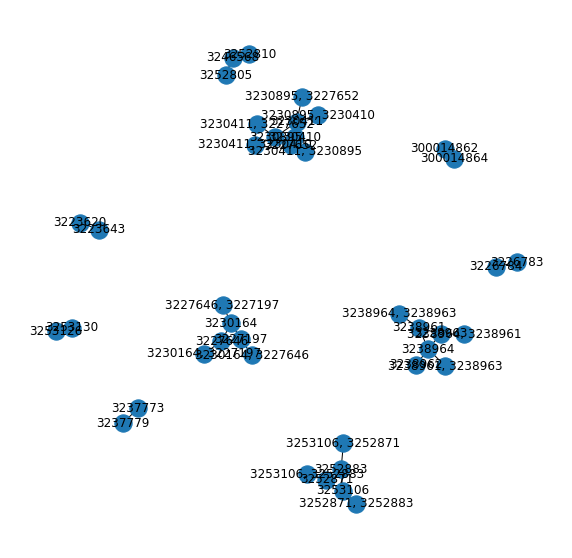

In [24]:
import networkx as nx

fig, ax=plt.subplots(figsize=(10,10))
GA=nx.from_pandas_edgelist(rules,source='antecedents',target='consequents')
nx.draw(GA,with_labels=True)
plt.show()